# Step 1: preprocess scATAC-seq data using pycisTopic

In [183]:
import pycisTopic
pycisTopic.__version__
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
import os
out_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs"
os.makedirs(out_dir, exist_ok = True)

In [184]:
fragments_dict = {
    "10x_multiome_lung": "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/atac_fragments.tsv.gz"
}

In [61]:
import pandas as pd
cell_data = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv", index_col = 0)
#cell_data = cell_data[cell_data['predicted.id']!=4]
cell_data['sample_id'] = "10x_multiome_lung"
cell_data.index = cell_data.index + '-' + cell_data['sample_id']
cell_data.shape

(2566, 19)

In [186]:
chromsizes = pd.read_table(
    "http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes",
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
chromsizes.head()

,Chromosome,Start,End
0,chr1,0,195471971
1,chr2,0,182113224
2,chrX,0,171031299
3,chr3,0,160039680
4,chr4,0,156508116


In [187]:
os.makedirs(os.path.join(out_dir, "consensus_peak_calling"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"), exist_ok = True)


bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = "predicted.id",
    sample_id_col = "sample_id",
    chromsizes = chromsizes,
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 10,
    normalize_bigwig = True,
    temp_dir = "/tmp",
    split_pattern = "-"
)


2025-03-09 12:52:35,772 cisTopic     WARNING  Non-string values detected in predicted.id column. These will be converted to strings.
2025-03-09 12:52:35,806 cisTopic     INFO     Splitting fragments by cell type.
2025-03-09 13:04:09,555 cisTopic     INFO     generating bigwig files


In [188]:
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv"), "wt") as f:
    for v in bw_paths:
        _ = f.write(f"{v}\t{bw_paths[v]}\n")

In [189]:
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        _ = f.write(f"{v}\t{bed_paths[v]}\n")

In [190]:
bw_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bw_paths.update({v: p})

In [191]:
bw_paths

{'2': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bw_files/2.bw',
 '3': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bw_files/3.bw',
 '5': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bw_files/5.bw',
 '1': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bw_files/1.bw'}

In [192]:
bed_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bed_paths.update({v: p})

In [193]:
bed_paths

{'2': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bed_files/2.fragments.tsv.gz',
 '3': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bed_files/3.fragments.tsv.gz',
 '5': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bed_files/5.fragments.tsv.gz',
 '1': '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bed_files/1.fragments.tsv.gz'}

In [194]:
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path = "/home/liangzhen/anaconda3/envs/scenicplus/bin/macs2"

os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok = True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(os.path.join(out_dir, "consensus_peak_calling/MACS")),
    genome_size = 'mm',
    n_cpu = 10,
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.05,
    _temp_dir = '/syn1/liangzhen/tmp',#ignore_reinit_error=True
)

2025-03-09 13:10:14,953	INFO worker.py:1724 -- Started a local Ray instance.


(macs_call_peak_ray pid=37734) 2025-03-09 13:10:23,190 cisTopic     INFO     Calling peaks for 5 with /home/liangzhen/anaconda3/envs/scenicplus/bin/macs2 callpeak --treatment /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bed_files/5.fragments.tsv.gz --name 5  --outdir /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/MACS --format BEDPE --gsize mm --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=37734) 2025-03-09 13:12:59,413 cisTopic     INFO     5 done!
(macs_call_peak_ray pid=37728) 2025-03-09 13:10:23,184 cisTopic     INFO     Calling peaks for 1 with /home/liangzhen/anaconda3/envs/scenicplus/bin/macs2 callpeak --treatment /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/pseudobulk_bed_files/1.fragments.tsv.gz --name 1  --outdir /syn1/liangzhen/jinhua_jil

In [195]:
from pycisTopic.iterative_peak_calling import get_consensus_peaks
# Other param
peak_half_width=250
path_to_blacklist="/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/mm10-blacklist.v2.bed"
# Get consensus peaks
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict = narrow_peak_dict,
    peak_half_width = peak_half_width,
    chromsizes = chromsizes,
    path_to_blacklist = path_to_blacklist)

2025-03-09 13:21:46,779 cisTopic     INFO     Extending and merging peaks per class
2025-03-09 13:22:35,067 cisTopic     INFO     Normalizing peak scores
2025-03-09 13:22:35,328 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2025-03-09 13:23:21,885 cisTopic     INFO     Done!


In [196]:
consensus_peaks.to_bed(
    path = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep =True,
    compression = 'infer',
    chain = False)

/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. 

In [197]:
#!/home/liangzhen/anaconda3/envs/scenicplus/bin/pycistopic tss gene_annotation_list | grep Mmusculus

In [198]:
!mkdir -p /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc

In [199]:
!/home/liangzhen/anaconda3/envs/scenicplus/bin/pycistopic tss get_tss --name mmusculus_gene_ensembl --server http://nov2020.archive.ensembl.org/ --ucsc mm10 --to-chrom-source ucsc --output /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc/tss.bed

- Get TSS annotation from Ensembl BioMart with the following settings:
  - biomart_name: "mmusculus_gene_ensembl"
  - biomart_host: "http://nov2020.archive.ensembl.org/"
  - transcript_type: ['protein_coding']
  - use_cache: True
- Getting chromosome sizes and alias mapping for "mm10" from UCSC.
- Update chromosome names in TSS annotation to "ucsc" chromosome names.
- Writing TSS annotation BED file to "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc/tss.bed".


In [200]:
!head /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc/tss.bed | column -t

#     Chromosome  Start  End      Gene  Score  Strand          Transcript_type
chrM  14144       14145  mt-Cytb  .     +      protein_coding
chrM  14069       14070  mt-Nd6   .     -      protein_coding
chrM  11741       11742  mt-Nd5   .     +      protein_coding
chrM  10166       10167  mt-Nd4   .     +      protein_coding
chrM  9876        9877   mt-Nd4l  .     +      protein_coding
chrM  9458        9459   mt-Nd3   .     +      protein_coding
chrM  8606        8607   mt-Co3   .     +      protein_coding
chrM  7926        7927   mt-Atp6  .     +      protein_coding
chrM  7765        7766   mt-Atp8  .     +      protein_coding


In [201]:
!/home/liangzhen/anaconda3/envs/scenicplus/bin/pycistopic qc \
    --fragments /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/atac_fragments.tsv.gz \
    --regions /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/consensus_peak_calling/consensus_regions.bed \
    --tss /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc/tss.bed \
    --output /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc/10x_multiome_lung

In [202]:
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
import matplotlib.pyplot as plt

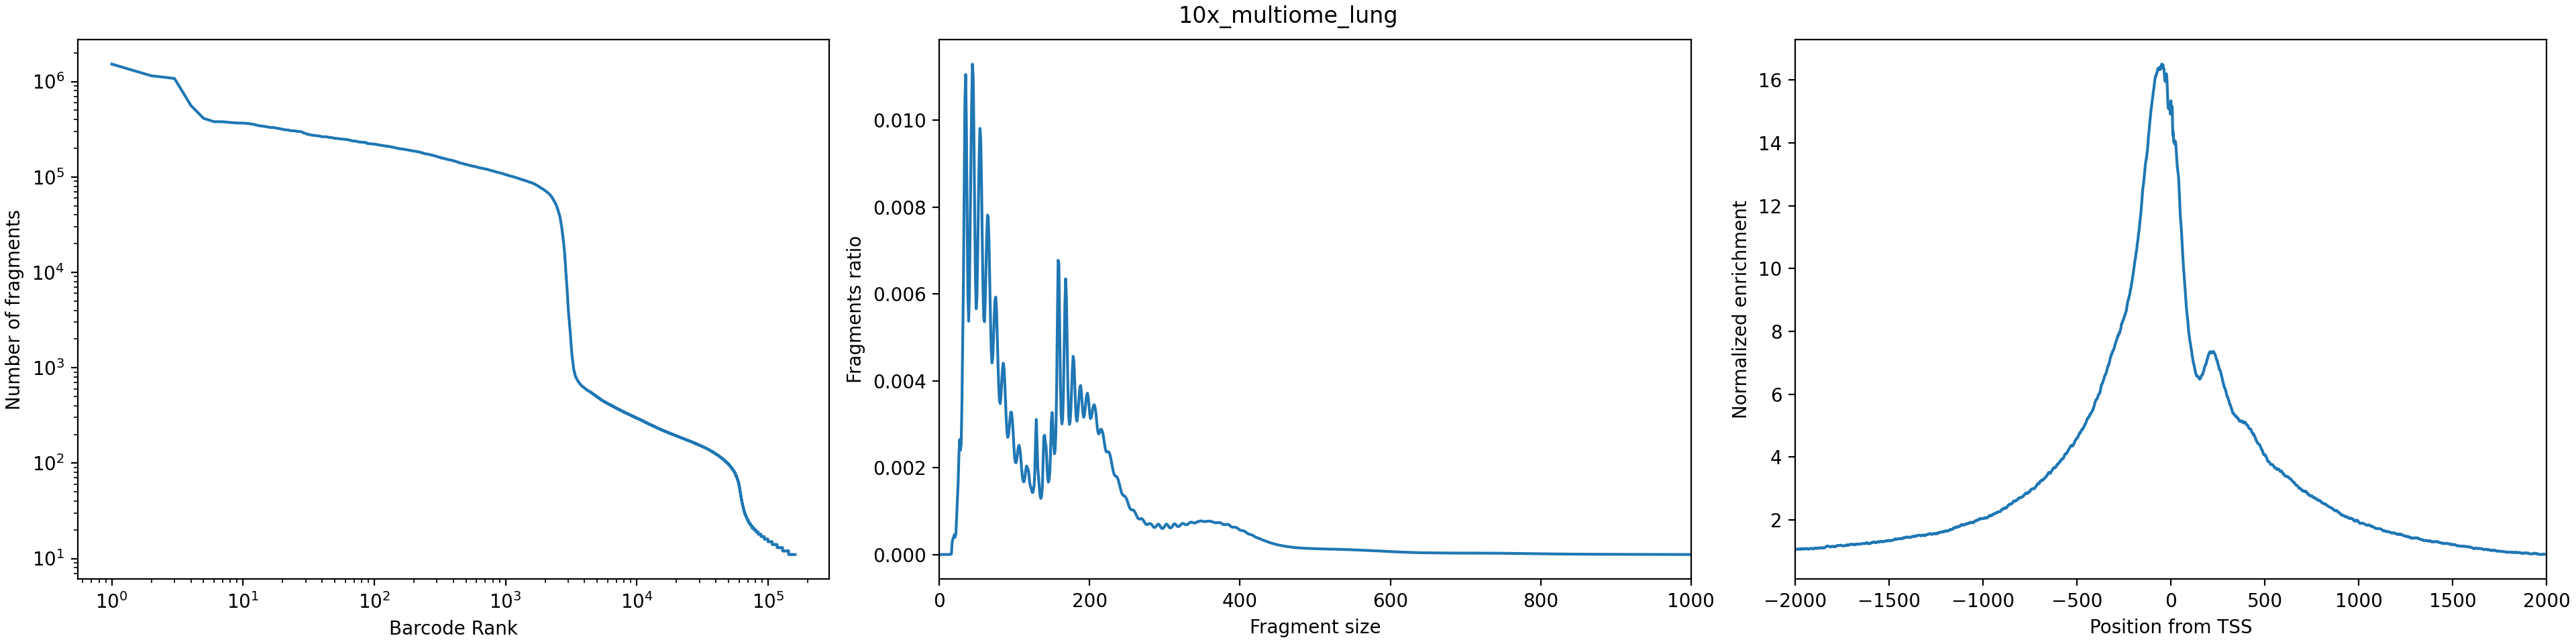

In [203]:
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc"
    )

In [204]:
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc",
            unique_fragments_threshold = None, # use automatic thresholding
            tss_enrichment_threshold = None, # use automatic thresholding
            frip_threshold = 0,
            use_automatic_thresholds = True,
    )

10x_multiome_lung:
	Using automatic threshold for unique fragments: 2652.643941967767
	Using automatic threshold for TSS enrichment: 8.584880725949398


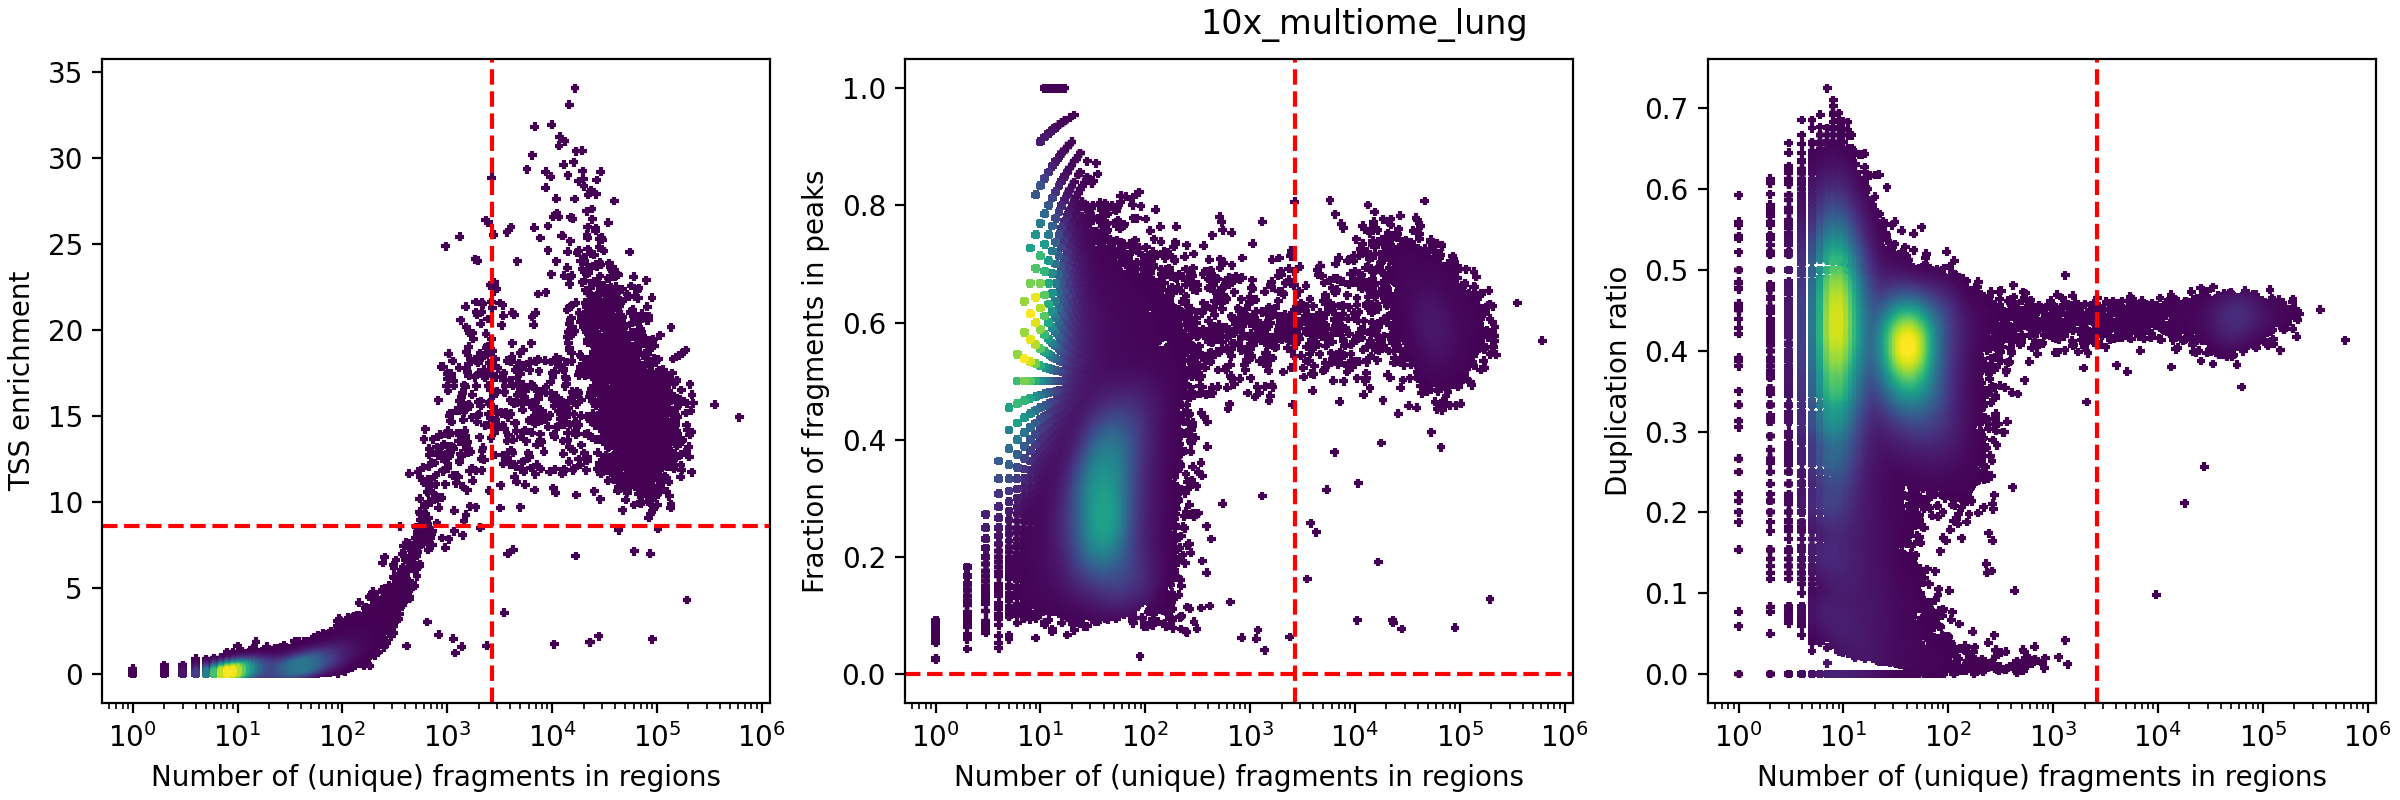

In [205]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc",
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

In [206]:
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/mm10-blacklist.v2.bed"
pycistopic_qc_output_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/qc"

from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import polars as pl

cistopic_obj_list = []
for sample_id in fragments_dict:
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[ sample_id_to_barcodes_passing_filters[sample_id] ]
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = list(sample_id_to_barcodes_passing_filters[sample_id][np.isin(sample_id_to_barcodes_passing_filters[sample_id],[ cell.replace('-10x_multiome_lung','') for cell in cell_data.index])]) ,
        n_cpu = 1,
        project = sample_id,
        split_pattern = '-'
    )
    cistopic_obj_list.append(cistopic_obj)

2025-03-09 13:42:49,545 cisTopic     INFO     Reading data for 10x_multiome_lung
2025-03-09 13:47:46,136 cisTopic     INFO     metrics provided!
2025-03-09 13:48:09,332 cisTopic     INFO     valid_bc provided, selecting barcodes!
2025-03-09 13:48:29,837 cisTopic     INFO     Counting fragments in regions
2025-03-09 13:51:19,327 cisTopic     INFO     Creating fragment matrix
2025-03-09 13:52:41,793 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-03-09 13:52:47,702 cisTopic     INFO     Removing blacklisted regions
2025-03-09 13:52:48,669 cisTopic     INFO     Creating CistopicObject
2025-03-09 13:52:52,787 cisTopic     INFO     Done!


In [207]:
len(list(sample_id_to_barcodes_passing_filters[sample_id][np.isin(sample_id_to_barcodes_passing_filters[sample_id],[ cell.replace('-10x_multiome_lung','') for cell in cell_data.index])]))

2500

In [208]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project 10x_multiome_lung with n_cells × n_regions = 2500 × 214180


In [209]:
import pandas as pd
cell_data = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv", index_col = 0)
cell_data['sample_id'] = "10x_multiome_lung"
cell_data.index = cell_data.index + '-' + cell_data['sample_id']
#cell_data.head()
cistopic_obj.add_cell_data(cell_data, split_pattern='-')

Columns ['sample_id'] will be overwritten


In [210]:
cistopic_obj.cell_data['predicted.id']

GCGTGCTAGGCTGGCT-1-10x_multiome_lung    3
GCCTATTGTTGAGCCG-1-10x_multiome_lung    3
GGATATTGTGCTTAGA-1-10x_multiome_lung    5
TTGAGCTAGTTATCTC-1-10x_multiome_lung    2
AGCTAAACAAGCCAGA-1-10x_multiome_lung    2
                                       ..
TAGCGGCTCATTACGA-1-10x_multiome_lung    2
CCAACATAGCCGCAAC-1-10x_multiome_lung    2
ACGAACAAGCTATATG-1-10x_multiome_lung    2
AAGCTAGAGGAGGTTA-1-10x_multiome_lung    3
GGGCAATAGGTACCGC-1-10x_multiome_lung    1
Name: predicted.id, Length: 2500, dtype: int64

In [211]:
!mkdir -p /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/

In [212]:
'''
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T
'''

"\nimport scrublet as scr\nscrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)\ndoublet_scores, predicted_doublets = scrub.scrub_doublets()\nscrub.plot_histogram();\nscrub.call_doublets(threshold=0.22)\nscrub.plot_histogram();\nscrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T\n"

In [213]:
#cistopic_obj.add_cell_data(scrublet, split_pattern = '-')
#sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)

In [214]:
# Remove doublets
#singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
#cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
#print(cistopic_obj_noDBL)

In [215]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj_before_models.pkl"), "wb")
)

In [217]:
cistopic_obj.cell_data['predicted.id'].value_counts()

3    1203
2     845
1     366
5      86
Name: predicted.id, dtype: int64

In [47]:
1203 + 845 + 366 + 86 -314

2186

# need to shutdown

In [ ]:
import pycisTopic
import os
out_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs"
os.makedirs(out_dir, exist_ok = True)

In [80]:
import pickle
cistopic_obj = pickle.load(open('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/cistopic_obj_before_models.pkl','rb') )

os.environ['MALLET_MEMORY'] = '200G'
from pycisTopic.lda_models import run_cgs_models_mallet
# Configure path Mallet
mallet_path="/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cistopic_obj,
    n_topics= [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    n_cpu=20,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial",
    save_path="/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial",
    mallet_path=mallet_path,
)

2024-12-22 15:30:09,100 cisTopic     INFO     Formatting input to corpus
2024-12-22 15:30:12,375 cisTopic     INFO     Running model with 2 topics
2024-12-22 15:30:12,377 LDAMalletWrapper INFO     Serializing temporary corpus to /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.txt
2024-12-22 15:30:52,290 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.txt --output /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.mallet
2024-12-22 15:32:45,071 LDAMalletWrapper INFO     Training MALLET LDA with: /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/Mallet-202108/bin/mallet train-topics --in

2024-12-22 22:20:41,220 cisTopic     INFO     Model with 15 topics done!
2024-12-22 22:20:41,221 cisTopic     INFO     Saving model with 15 topics at /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial
2024-12-22 22:20:41,412 cisTopic     INFO     Running model with 20 topics
2024-12-22 22:20:41,413 LDAMalletWrapper INFO     Serializing temporary corpus to /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.txt
2024-12-22 22:21:24,694 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.txt --output /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.mallet
2024-12-22 22:22:30,289 LDAMall

2024-12-23 07:28:31,352 LDAMalletWrapper INFO     loading assigned topics from /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/be4a6e_state.mallet.gz
2024-12-23 07:29:16,635 cisTopic     INFO     Model with 35 topics done!
2024-12-23 07:29:16,636 cisTopic     INFO     Saving model with 35 topics at /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial
2024-12-23 07:29:17,024 cisTopic     INFO     Running model with 40 topics
2024-12-23 07:29:17,026 LDAMalletWrapper INFO     Serializing temporary corpus to /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/tutorial/corpus.txt
2024-12-23 07:30:00,403 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /syn1/liangzhen/jinhua_jilab_project/result/scATA

In [81]:
pickle.dump(
    models,
    open(os.path.join(out_dir, "models.pkl"), "wb")
)

# load model

In [1]:
import os
out_dir = "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs"
os.makedirs(out_dir, exist_ok = True)

In [2]:
import pickle
import os
models = pickle.load(open(os.path.join(out_dir, "models.pkl"), "rb"))

/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-09 19:53:11,193	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
print('completed!')

completed!


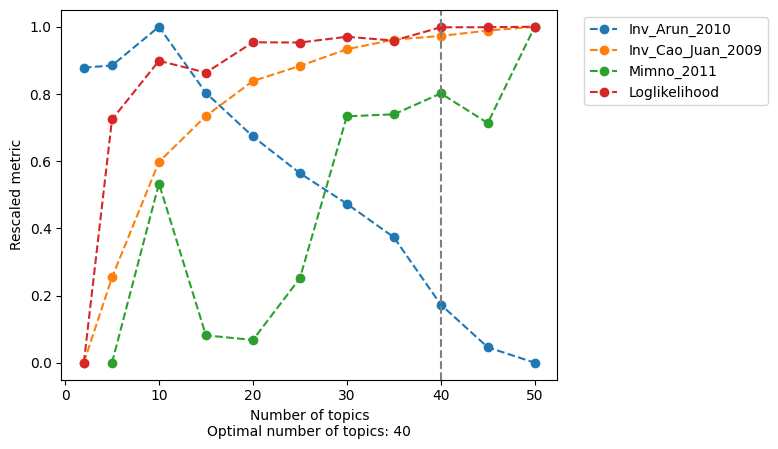

In [4]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(
    models,
    select_model = 40,
    return_model = True
)

In [5]:
import pickle
cistopic_obj = pickle.load(open('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/cistopic_obj_before_models.pkl','rb') )
cistopic_obj.add_LDA_model(model)

In [6]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [7]:
import pickle
cistopic_obj = pickle.load(open('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/cistopic_obj.pkl','rb') )

In [8]:
from pycisTopic.topic_binarization import binarize_topics

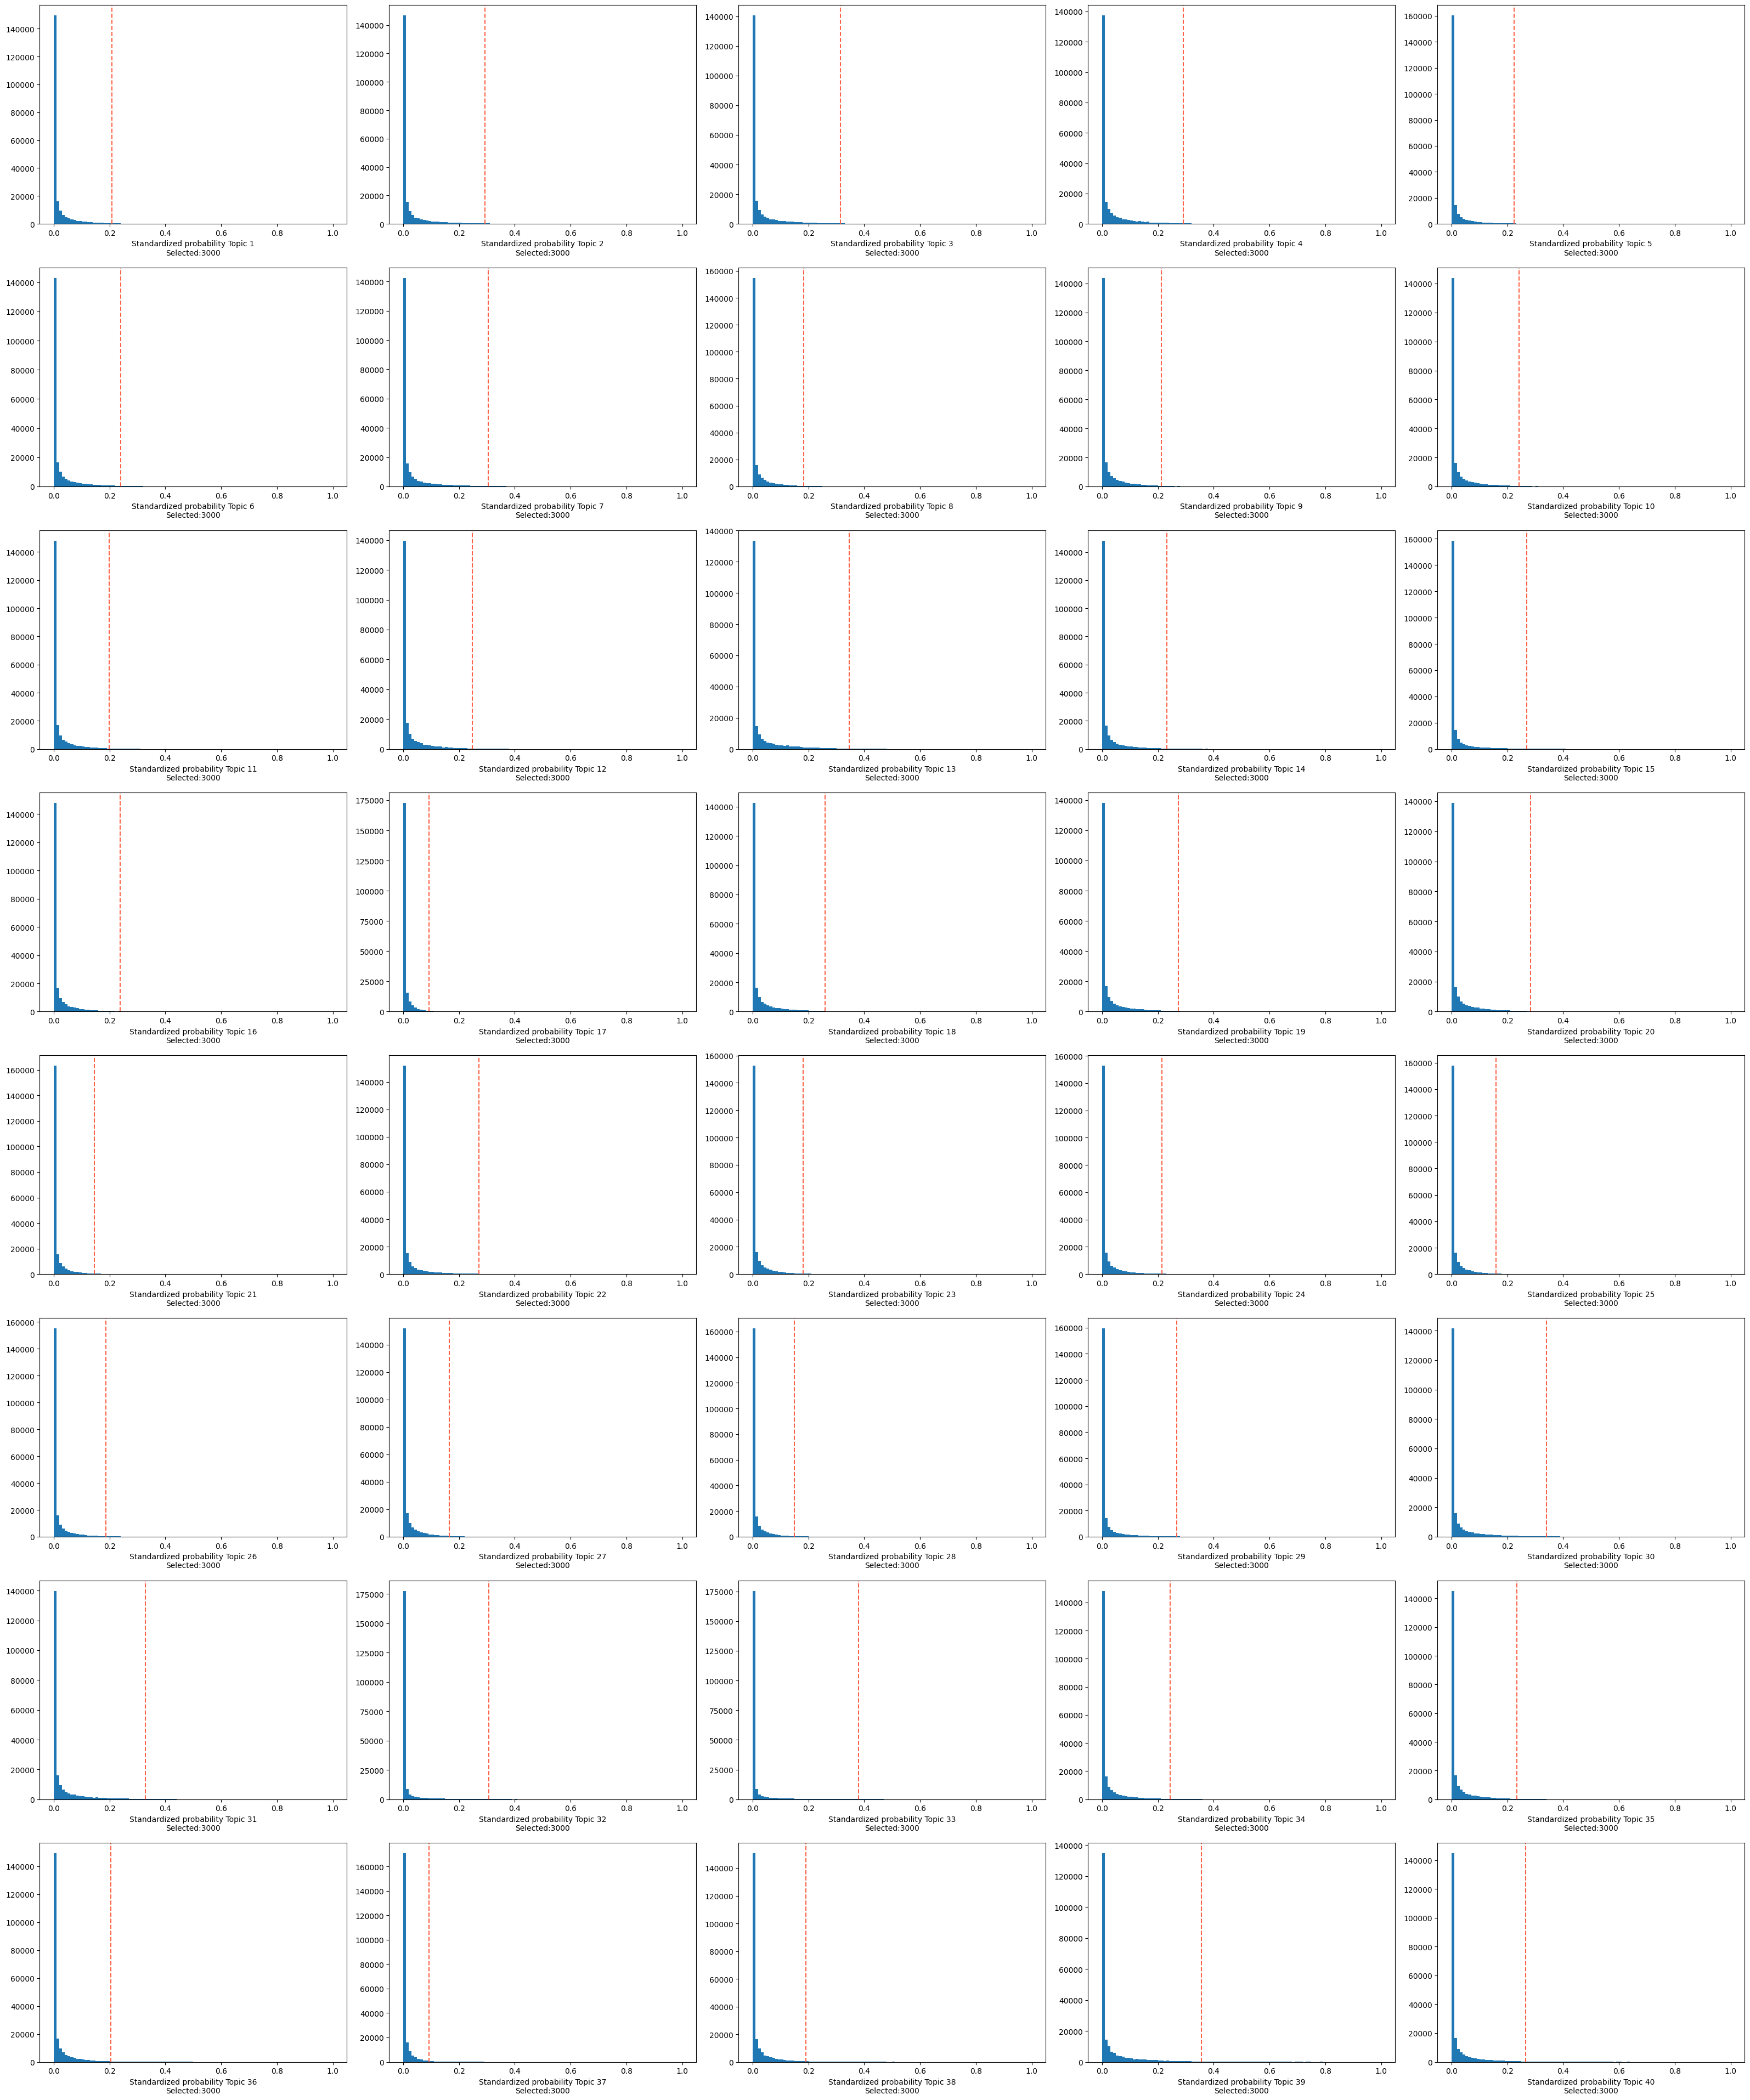

In [9]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_obj, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)

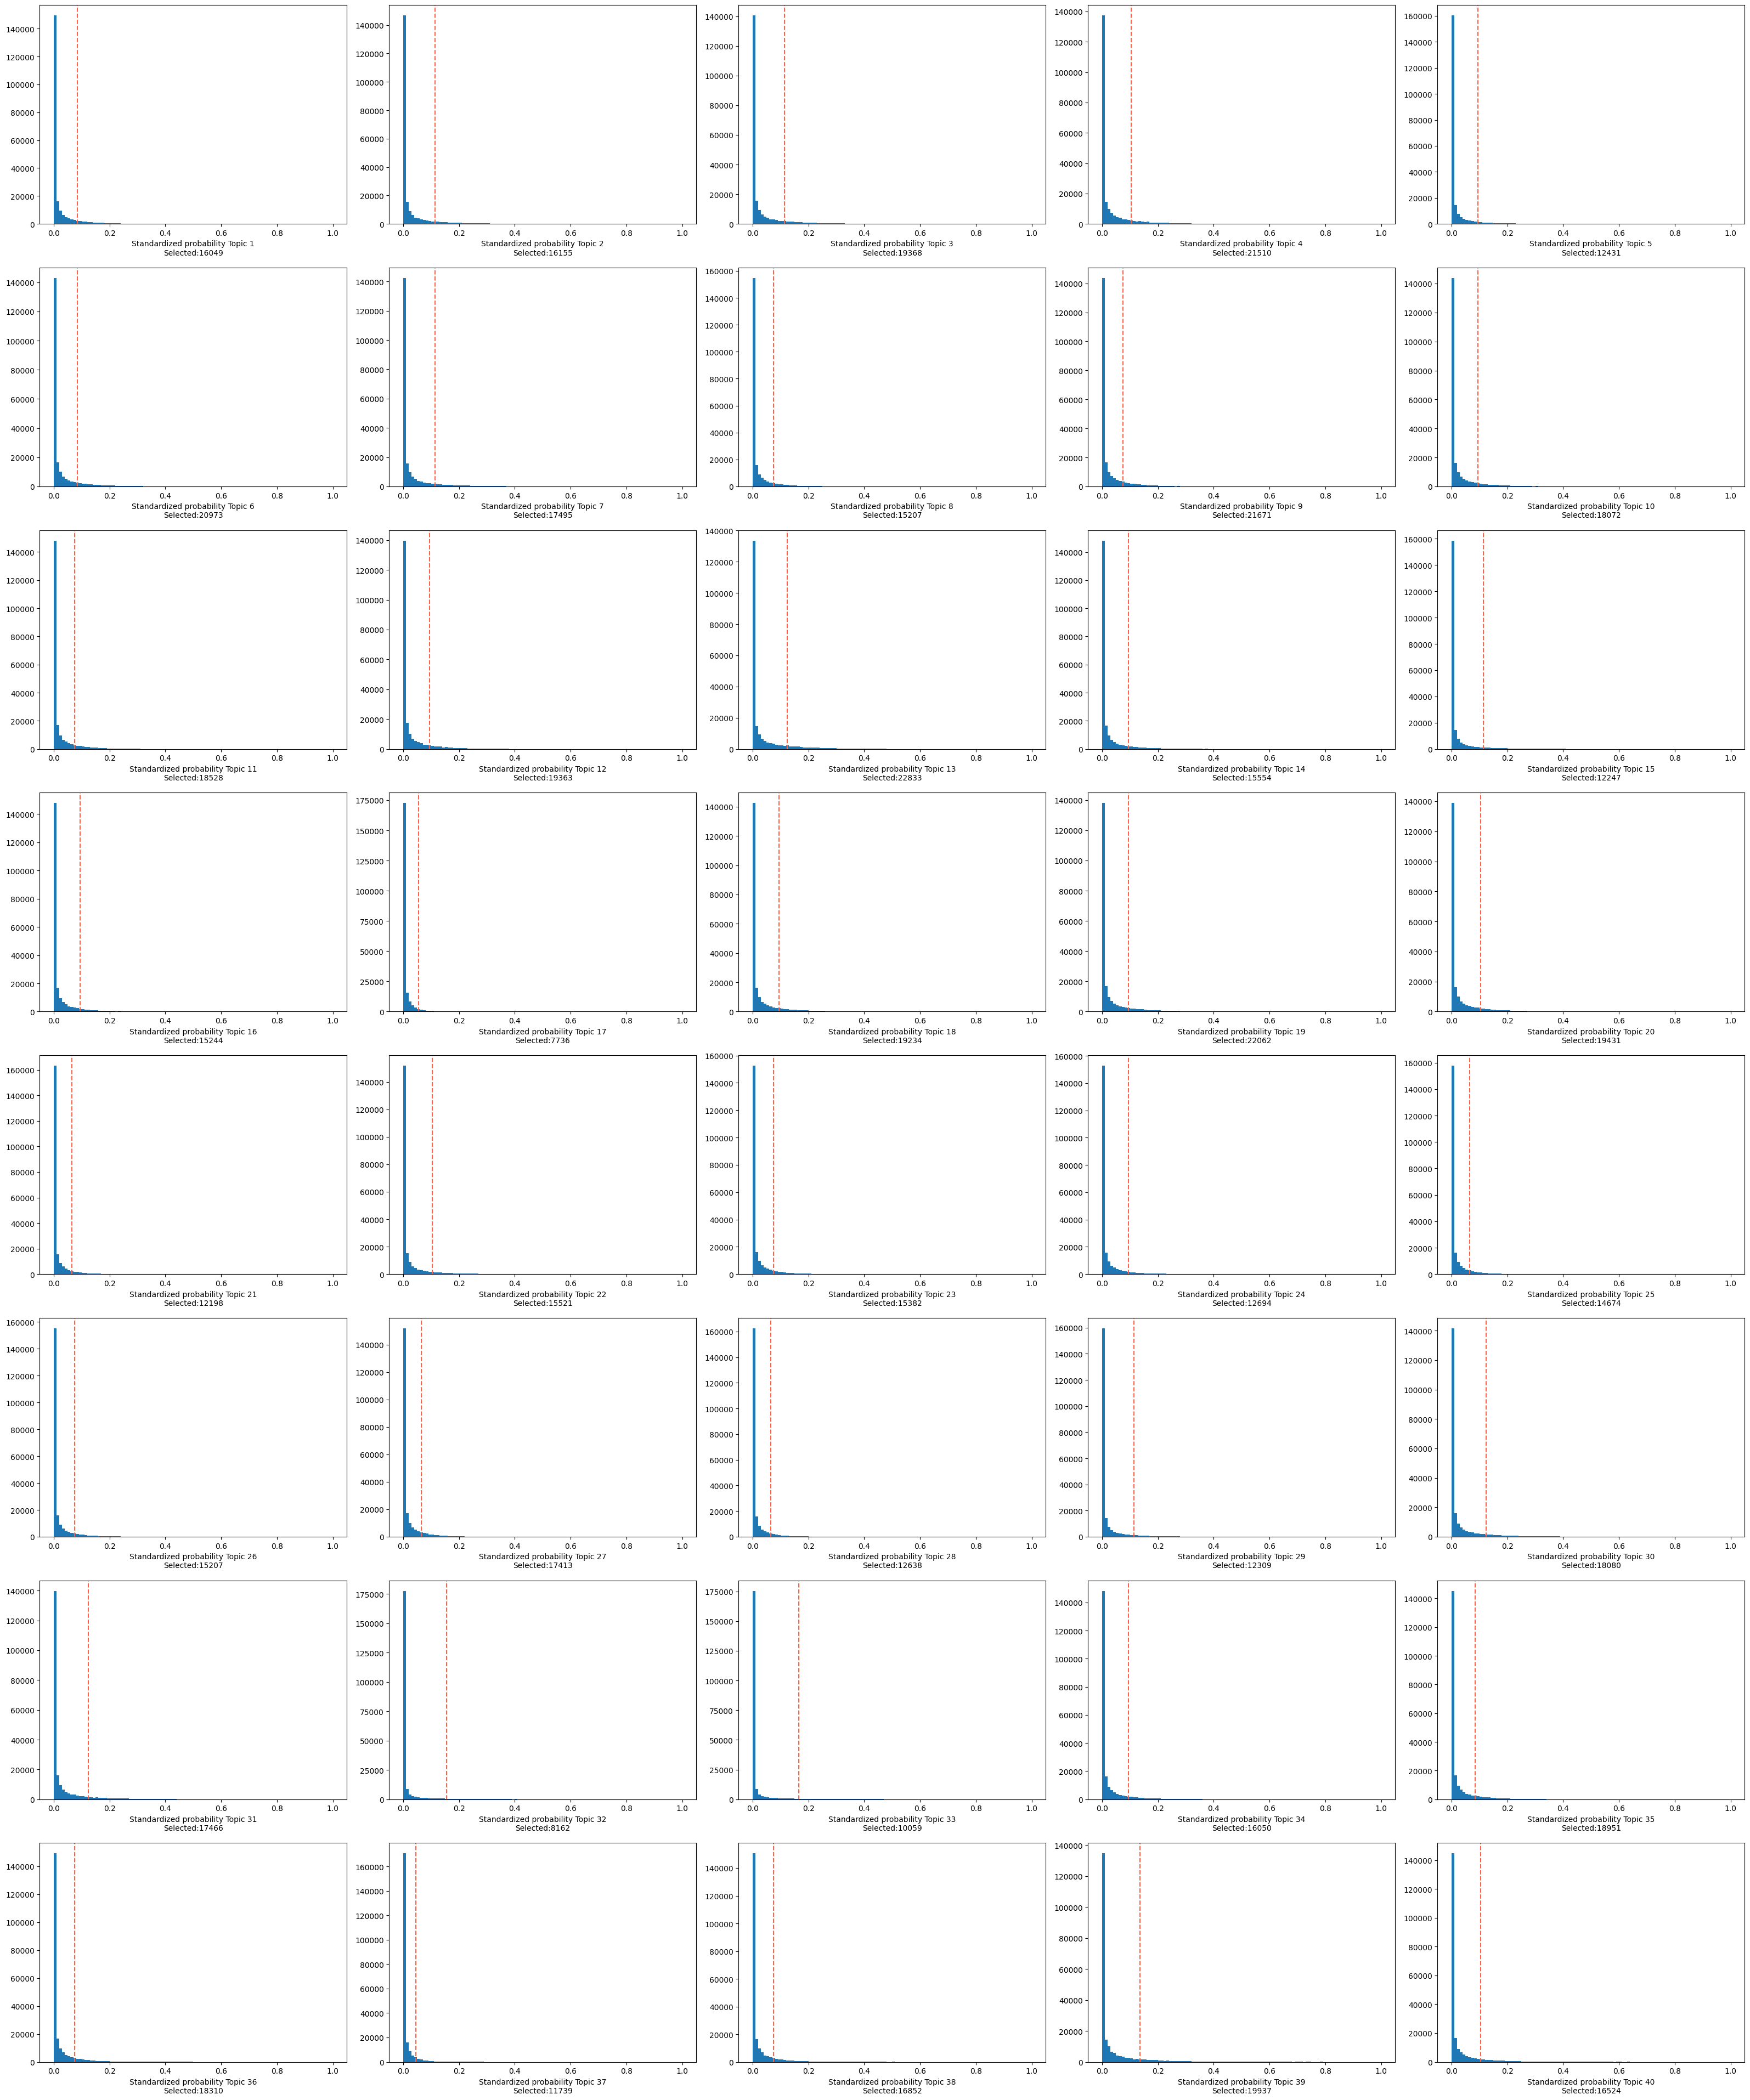

In [10]:
region_bin_topics_otsu = binarize_topics(
    cistopic_obj, method='otsu',
    plot=True, num_columns=5
)

In [ ]:
binarized_cell_topic = binarize_topics(
    cistopic_obj,
    target='cell',
    method='li',
    plot=True,
    num_columns=5, nbins=100)

In [12]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img

In [13]:
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [14]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

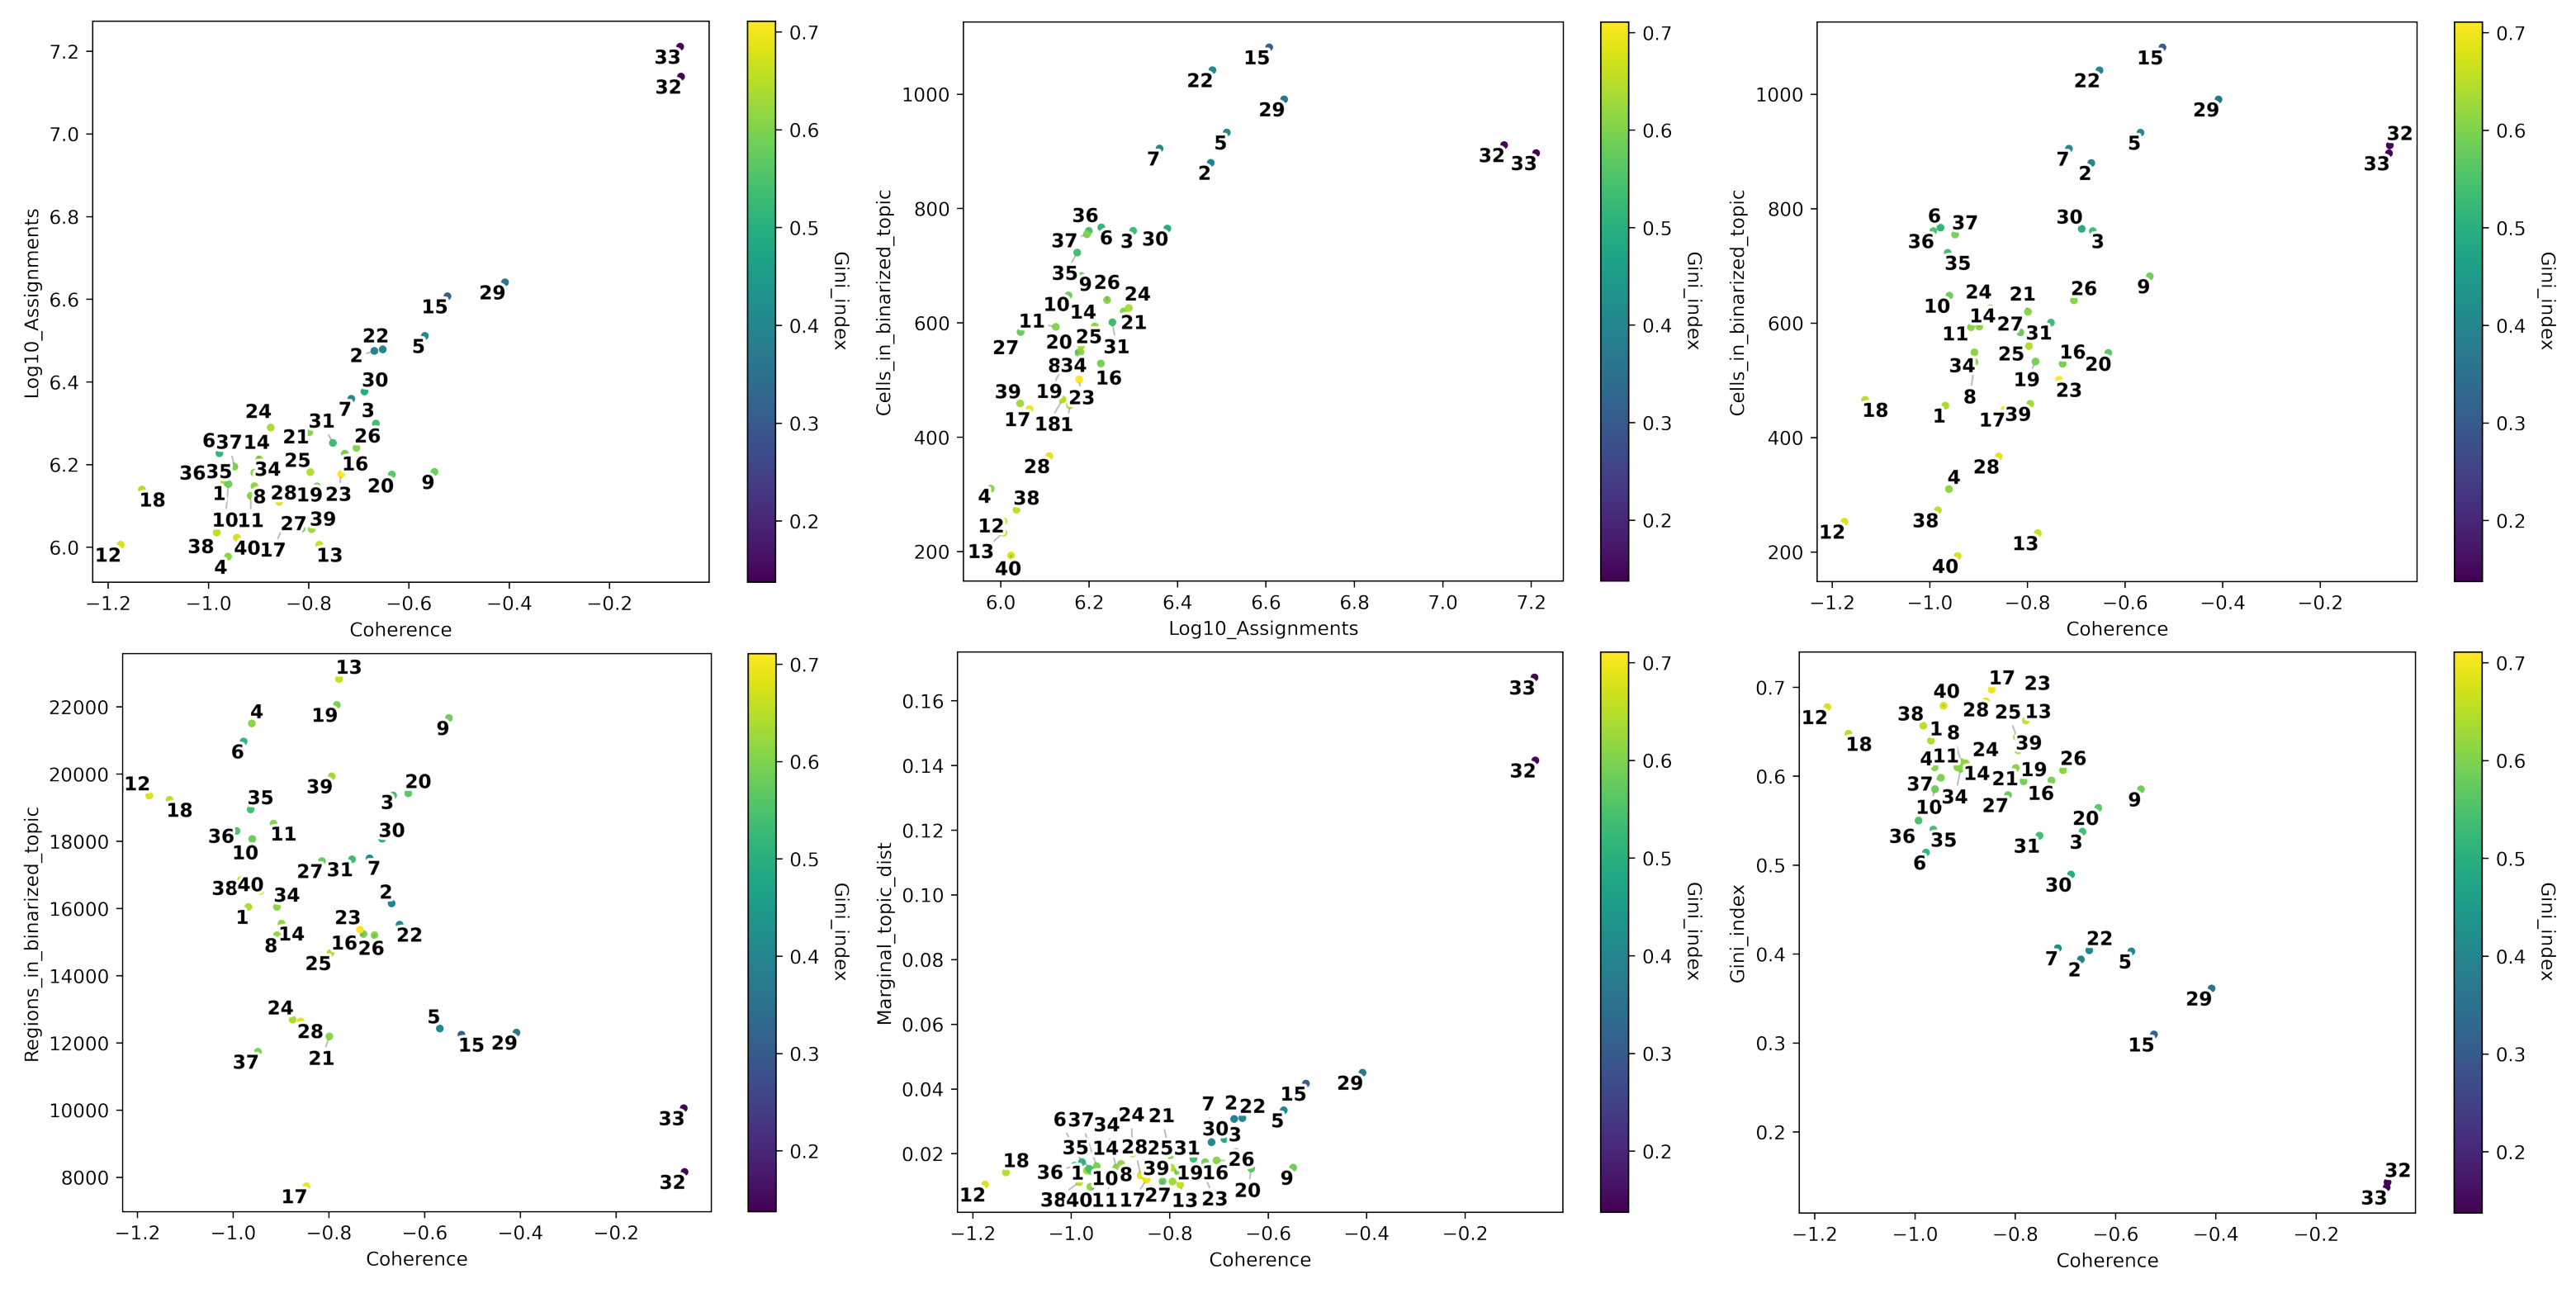

In [15]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

In [16]:
cistopic_obj.cell_data['predicted.id'] = cistopic_obj.cell_data['predicted.id'].astype('str')
topic_annot = topic_annotation(
    cistopic_obj,
    annot_var='predicted.id',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)

In [17]:
topic_annot

,predicted.id,Ratio_cells_in_topic,Ratio_group_in_population,is_general
Topic1,"3, 5",0.1824,0.5156,False
Topic2,1,0.352,0.1464,True
Topic3,"5, 2",0.3044,0.3724,False
Topic4,"1, 2",0.124,0.4844,False
Topic5,"3, 5",0.3732,0.5156,False
Topic6,3,0.3068,0.4812,False
Topic7,3,0.362,0.4812,False
Topic8,"3, 5, 1",0.2128,0.662,False
Topic9,3,0.2728,0.4812,False
Topic10,"3, 5",0.2592,0.5156,False


In [18]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
import numpy as np

In [19]:
imputed_acc_obj = impute_accessibility(
    cistopic_obj,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2025-03-09 19:54:31,517 cisTopic     INFO     Imputing region accessibility
2025-03-09 19:54:31,517 cisTopic     INFO     Impute region accessibility for regions 0-20000
2025-03-09 19:54:32,160 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2025-03-09 19:54:32,827 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2025-03-09 19:54:33,488 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2025-03-09 19:54:34,149 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2025-03-09 19:54:34,812 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2025-03-09 19:54:35,479 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2025-03-09 19:54:36,137 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2025-03-09 19:54:36,797 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2025-03-09 19:54:37,457 cisTopic     

In [20]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2025-03-09 19:54:38,625 cisTopic     INFO     Normalizing imputed data
2025-03-09 19:54:42,501 cisTopic     INFO     Done!


2025-03-09 19:54:42,506 cisTopic     INFO     Calculating mean
2025-03-09 19:54:43,072 cisTopic     INFO     Calculating variance


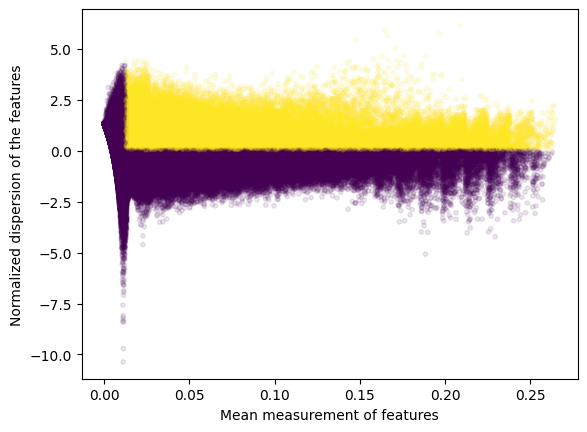

2025-03-09 19:54:52,339 cisTopic     INFO     Done!


In [21]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

In [22]:
cistopic_obj.cell_data

,fraction_of_fragments_in_peaks,log10_total_fragments_in_peaks_count,total_fragments_in_peaks_count,pdf_values_for_tss_enrichment,log10_total_fragments_count,barcode,cisTopic_log_nr_frag,pdf_values_for_duplication_ratio,nucleosome_signal,cisTopic_log_nr_acc,...,predicted.id,prediction.score.2,prediction.score.1,prediction.score.3,prediction.score.4,prediction.score.5,prediction.score.max,umap_1,umap_2,sample_id
GCGTGCTAGGCTGGCT-1-10x_multiome_lung,0.557082,4.984082,96400,0.001810,5.224932,GCGTGCTAGGCTGGCT-1,4.738614,0.704174,0.930100,4.551938,...,3,0.0,0.023995,0.933563,0.000000,0.042442,0.933563,3.870148,1.395017,10x_multiome_lung
GCCTATTGTTGAGCCG-1-10x_multiome_lung,0.541672,4.940576,87211,0.004287,5.192049,GCCTATTGTTGAGCCG-1,4.706573,0.386300,0.976270,4.548119,...,3,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,2.416445,0.890715,10x_multiome_lung
GGATATTGTGCTTAGA-1-10x_multiome_lung,0.634087,4.990947,97936,0.006435,5.178905,GGATATTGTGCTTAGA-1,4.717454,0.216058,0.556463,4.545196,...,5,0.0,0.000000,0.152473,0.000000,0.847527,0.847527,2.040531,3.947003,10x_multiome_lung
TTGAGCTAGTTATCTC-1-10x_multiome_lung,0.552694,4.932113,85528,0.005365,5.175291,TTGAGCTAGTTATCTC-1,4.697613,0.405733,0.992228,4.557206,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-2.727284,1.721628,10x_multiome_lung
AGCTAAACAAGCCAGA-1-10x_multiome_lung,0.550216,5.136318,136872,0.001266,5.383474,AGCTAAACAAGCCAGA-1,4.903014,0.257768,1.269994,4.674503,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-4.607337,1.813633,10x_multiome_lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGCGGCTCATTACGA-1-10x_multiome_lung,0.664029,4.294091,19682,0.000239,4.470528,TAGCGGCTCATTACGA-1,4.067963,0.036403,0.573149,4.007193,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-2.426668,0.238268,10x_multiome_lung
CCAACATAGCCGCAAC-1-10x_multiome_lung,0.522458,3.791199,6182,0.000072,4.058464,CCAACATAGCCGCAAC-1,3.519566,0.018467,0.613859,3.472464,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-4.710665,1.500164,10x_multiome_lung
ACGAACAAGCTATATG-1-10x_multiome_lung,0.647140,3.679428,4779,0.000195,3.874714,ACGAACAAGCTATATG-1,3.467608,0.030754,0.667441,3.446071,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-3.106705,2.375972,10x_multiome_lung
AAGCTAGAGGAGGTTA-1-10x_multiome_lung,0.595398,4.098851,12555,0.000072,4.314689,AAGCTAGAGGAGGTTA-1,3.846337,0.039843,0.555572,3.739256,...,3,0.0,0.419470,0.568939,0.011591,0.000000,0.568939,3.918392,-3.397689,10x_multiome_lung


In [23]:
markers_dict= find_diff_features(
    cistopic_obj,
    imputed_acc_obj,
    variable='predicted.id',
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=5,
    _temp_dir='/syn1/liangzhen/tmp',
    split_pattern = '-'
)

2025-03-09 19:54:59,226	INFO worker.py:1724 -- Started a local Ray instance.


2025-03-09 19:55:00,809 cisTopic     INFO     Subsetting data for 1 (366 of 2500)
2025-03-09 19:55:06,039 cisTopic     INFO     Computing p-value for 1
2025-03-09 19:55:30,541 cisTopic     INFO     Computing log2FC for 1
2025-03-09 19:55:32,086 cisTopic     INFO     1 done!
2025-03-09 19:55:32,131 cisTopic     INFO     Subsetting data for 2 (845 of 2500)
2025-03-09 19:55:32,570 cisTopic     INFO     Computing p-value for 2
2025-03-09 19:55:54,828 cisTopic     INFO     Computing log2FC for 2
2025-03-09 19:55:54,946 cisTopic     INFO     2 done!
2025-03-09 19:55:54,991 cisTopic     INFO     Subsetting data for 3 (1203 of 2500)
2025-03-09 19:55:55,446 cisTopic     INFO     Computing p-value for 3
2025-03-09 19:56:17,471 cisTopic     INFO     Computing log2FC for 3
2025-03-09 19:56:17,587 cisTopic     INFO     3 done!
2025-03-09 19:56:17,634 cisTopic     INFO     Subsetting data for 5 (86 of 2500)
2025-03-09 19:56:18,039 cisTopic     INFO     Computing p-value for 5
2025-03-09 19:56:40,454

2025-03-09 19:56:46,658 cisTopic     INFO     Running UMAP


/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


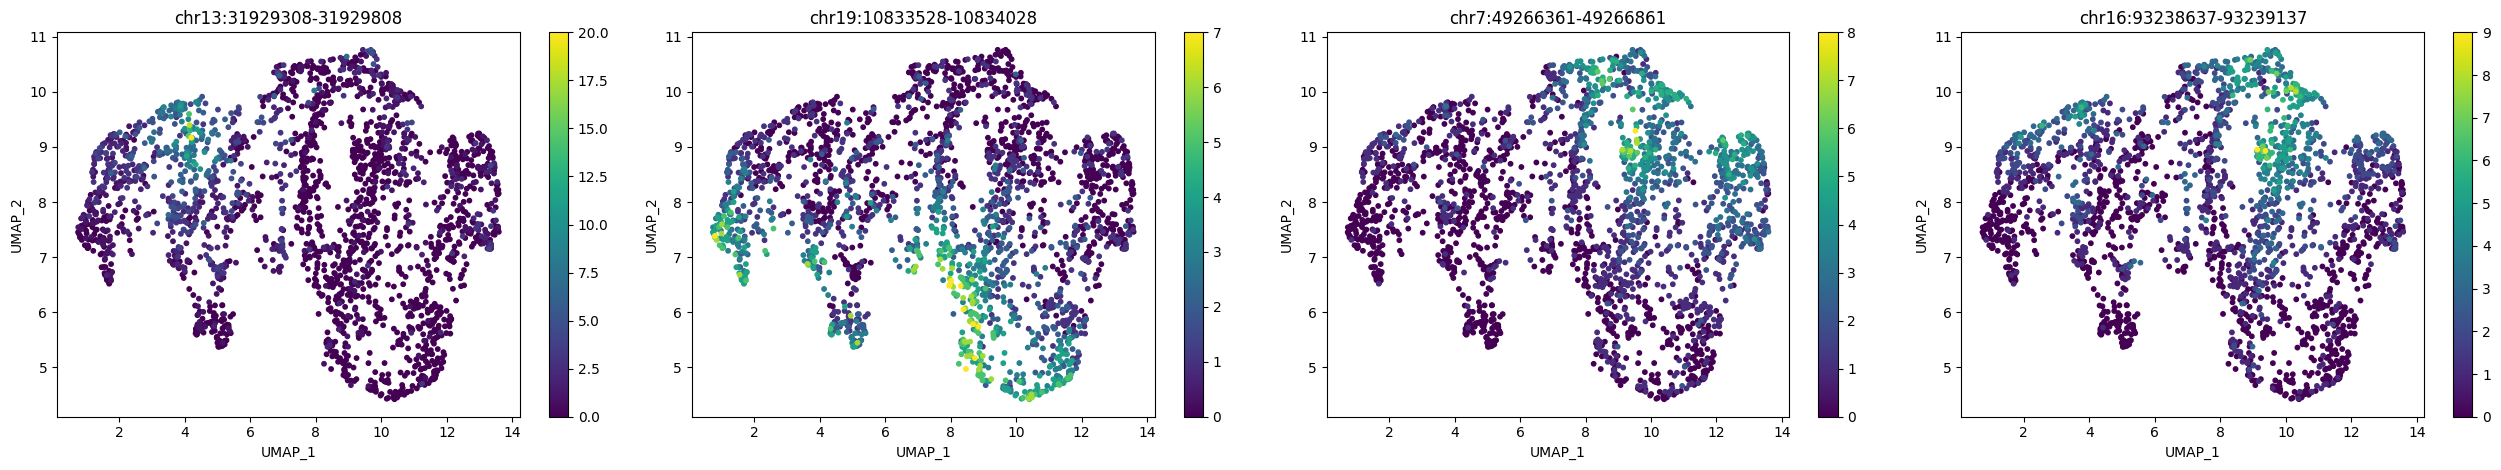

In [24]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)
run_umap(
    cistopic_obj,
    target  = 'cell', scale=True)
from pycisTopic.clust_vis import plot_imputed_features
plot_imputed_features(
    cistopic_obj,
    reduction_name='UMAP',
    imputed_data=imputed_acc_obj,
    features=[markers_dict[x].index.tolist()[0] for x in ['1', '2', '3', '5']],
    scale=False,
    num_columns=4
)

In [25]:
os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARs_cell_type"), exist_ok = True)

In [26]:
from pycisTopic.utils import region_names_to_coordinates

In [27]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [28]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [29]:
for cell_type in markers_dict:
    region_names_to_coordinates(
        markers_dict[cell_type].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "DARs_cell_type", f"{cell_type}.bed"),
        sep = "\t",
        header = False, index = False
    )

# Step 2: Preprocessing the scRNA-seq data

In [30]:
import scanpy as sc

In [31]:
import pickle
cistopic_obj = pickle.load(open('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/outs/cistopic_obj.pkl','rb') )

In [32]:
cistopic_obj.cell_data

,fraction_of_fragments_in_peaks,log10_total_fragments_in_peaks_count,total_fragments_in_peaks_count,pdf_values_for_tss_enrichment,log10_total_fragments_count,barcode,cisTopic_log_nr_frag,pdf_values_for_duplication_ratio,nucleosome_signal,cisTopic_log_nr_acc,...,predicted.id,prediction.score.2,prediction.score.1,prediction.score.3,prediction.score.4,prediction.score.5,prediction.score.max,umap_1,umap_2,sample_id
GCGTGCTAGGCTGGCT-1-10x_multiome_lung,0.557082,4.984082,96400,0.001810,5.224932,GCGTGCTAGGCTGGCT-1,4.738614,0.704174,0.930100,4.551938,...,3,0.0,0.023995,0.933563,0.000000,0.042442,0.933563,3.870148,1.395017,10x_multiome_lung
GCCTATTGTTGAGCCG-1-10x_multiome_lung,0.541672,4.940576,87211,0.004287,5.192049,GCCTATTGTTGAGCCG-1,4.706573,0.386300,0.976270,4.548119,...,3,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,2.416445,0.890715,10x_multiome_lung
GGATATTGTGCTTAGA-1-10x_multiome_lung,0.634087,4.990947,97936,0.006435,5.178905,GGATATTGTGCTTAGA-1,4.717454,0.216058,0.556463,4.545196,...,5,0.0,0.000000,0.152473,0.000000,0.847527,0.847527,2.040531,3.947003,10x_multiome_lung
TTGAGCTAGTTATCTC-1-10x_multiome_lung,0.552694,4.932113,85528,0.005365,5.175291,TTGAGCTAGTTATCTC-1,4.697613,0.405733,0.992228,4.557206,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-2.727284,1.721628,10x_multiome_lung
AGCTAAACAAGCCAGA-1-10x_multiome_lung,0.550216,5.136318,136872,0.001266,5.383474,AGCTAAACAAGCCAGA-1,4.903014,0.257768,1.269994,4.674503,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-4.607337,1.813633,10x_multiome_lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGCGGCTCATTACGA-1-10x_multiome_lung,0.664029,4.294091,19682,0.000239,4.470528,TAGCGGCTCATTACGA-1,4.067963,0.036403,0.573149,4.007193,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-2.426668,0.238268,10x_multiome_lung
CCAACATAGCCGCAAC-1-10x_multiome_lung,0.522458,3.791199,6182,0.000072,4.058464,CCAACATAGCCGCAAC-1,3.519566,0.018467,0.613859,3.472464,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-4.710665,1.500164,10x_multiome_lung
ACGAACAAGCTATATG-1-10x_multiome_lung,0.647140,3.679428,4779,0.000195,3.874714,ACGAACAAGCTATATG-1,3.467608,0.030754,0.667441,3.446071,...,2,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,-3.106705,2.375972,10x_multiome_lung
AAGCTAGAGGAGGTTA-1-10x_multiome_lung,0.595398,4.098851,12555,0.000072,4.314689,AAGCTAGAGGAGGTTA-1,3.846337,0.039843,0.555572,3.739256,...,3,0.0,0.419470,0.568939,0.011591,0.000000,0.568939,3.918392,-3.397689,10x_multiome_lung


In [63]:
adata = sc.read_10x_mtx(
    "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/filtered_feature_bc_matrix/",
    var_names = "gene_symbols"
)

In [64]:
adata.var_names_make_unique()

In [65]:
adata

AnnData object with n_obs × n_vars = 3039 × 32285
    var: 'gene_ids', 'feature_types'

In [66]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [38]:
singlet_df = cistopic_obj.cell_data.copy()

In [39]:
adata = adata[[ cell.replace('-10x_multiome_lung','') for cell in 
               singlet_df.index[singlet_df['predicted.id'].isin([1,2,3,5])]
              ],]

In [40]:
adata.obs.columns

Index(['n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

In [62]:
adata

AnnData object with n_obs × n_vars = 2500 × 1624
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [42]:
adata.obs.index = [ cell + '-10x_multiome_lung' for cell in adata.obs.index]

In [43]:
adata.obs_names[1:3]

Index(['GCCTATTGTTGAGCCG-1-10x_multiome_lung', 'GGATATTGTGCTTAGA-1-10x_multiome_lung'], dtype='object')

In [44]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [45]:
adata.write("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/adata.h5ad")

... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


# Step 3: (Optional but recommended) generate a custom cisTarget database

# Step 4: Run SCENIC+ using SnakeMake

# Downstream analysis

In [9]:
import mudata
scplus_mdata = mudata.read("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scenicplus/scplus_pipeline/Snakemake/scplusmdata.h5mu")

/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/liangzhen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [10]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)

In [11]:
import matplotlib.pyplot as plt

In [12]:
scplus_mdata

MuData object with n_obs × n_vars = 2500 × 246458
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	2500 x 32285
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      obsm:	'X_pca', 'X_umap'
    scATAC_counts:	2500 x 214041
      obs:	'fraction_of_fragments_in_peaks', 'log10_total_fragments_in_peaks_count', 'total_fragments_in_peaks_count', 'pdf_values_for_tss_enrichment', 'log10_total_fragments_count', 'barcode', 'cisTopic_log_nr_frag', 'pdf_values_for_duplication_ratio', 'nucleosome_signal', 'cisTopic_log_nr_acc', 'unique_fragments_in_peaks_count', 'unique_fragments_count', 'duplication_ratio', 'log10_unique_fragments_count', 'pdf_values_for_fraction_of_fragments_in_peaks', 'log10_unique_fragments_in_peaks_count', 'cisTopic_nr_acc', 'barcode_rank', 'cisTopic_nr_frag', 'duplication_count', 'tss_enrichment', 'total_fragments_count', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'predicted.id', 'prediction.score.2', 'prediction.score.1', 'prediction.score.3', 'prediction.score.4', 'prediction.score.5', 'prediction.score.max', 'umap_1', 'umap_2', 'sample_id'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	2500 x 24
    direct_region_based_AUC:	2500 x 24
    extended_gene_based_AUC:	2500 x 42
    extended_region_based_AUC:	2500 x 42

In [8]:
scplus_mdata.obs['scATAC_counts:predicted.id'] = scplus_mdata.obs['scATAC_counts:predicted.id'].astype('str')

In [33]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, aes, scale_fill_distiller, 
    geom_tile, theme, element_text, element_blank)
from plotnine.facets import facet_grid
import plotnine
from typing import List, Union, Optional, Tuple
from mudata import MuData
from scenicplus.scenicplus_mudata import ScenicPlusMuData

def _scale(X: pd.DataFrame) -> pd.DataFrame:
    return (X - X.min()) / (X.max() - X.min())

def generate_dotplot_df(
    size_matrix: pd.DataFrame,
    color_matrix: pd.DataFrame,
    group_by: List[str],
    size_features: List[str], # size_features, color_features and feature_names the order should correspond, e.g. color_features, size_features, feature_names = scplus_mudata.uns["direct_e_regulon_metadata"][["Region_signature_name", "Gene_signature_name", "eRegulon_name"]].drop_duplicates().values.T
    color_features: List[str],
    feature_names: List[str],
    scale_size_matrix: bool = True,
    scale_color_matrix: bool = True,
    group_name: str = "group",
    size_name: str = "size_variable",
    color_name: str = "color_variable",
    feature_name: str = "eRegulon") -> pd.DataFrame:
    # Validate input
    if not all(size_matrix.index == color_matrix.index):
        raise ValueError("Both size_matrix and color_matrix should have the same index")
    if len(group_by) != len(size_matrix.index):
        raise ValueError("Length of group_by does not match with the index")
    if len(size_features) != len(color_features) != len(feature_names):
        raise ValueError("The length of 'size_features', 'color_features' and 'feature_names' should be equal!")
    # Subset and order for features
    size_matrix = size_matrix[size_features]
    color_matrix = color_matrix[color_features]
    # Calculate mean by group_by variable
    color_matrix_avg = color_matrix.groupby(group_by).mean()
    size_matrix_avg = size_matrix.groupby(group_by).mean()
    # Scale matrices
    color_matrix_avg = _scale(color_matrix_avg) if scale_color_matrix else color_matrix_avg
    size_matrix_avg = _scale(size_matrix_avg) if scale_size_matrix else size_matrix_avg
    # Transform dataframe into long format
    color_matrix_avg = color_matrix_avg.stack().reset_index()
    size_matrix_avg = size_matrix_avg.stack().reset_index()
    color_matrix_avg.columns = [group_name, "color_features", color_name]
    size_matrix_avg.columns = [group_name, "size_features", size_name]
    # map between color and size feature names to feature names
    color_features_to_name = dict(zip(color_features, feature_names))
    size_features_to_name = dict(zip(size_features, feature_names))
    # Add feature names to dataframe
    color_matrix_avg[feature_name] = [
        color_features_to_name[f] for f in color_matrix_avg["color_features"]]
    size_matrix_avg[feature_name] = [
        size_features_to_name[f] for f in size_matrix_avg["size_features"]]
    color_matrix_avg = color_matrix_avg.drop("color_features", axis = 1)
    size_matrix_avg = size_matrix_avg.drop("size_features", axis = 1)
    dotplot_df = color_matrix_avg.merge(
        size_matrix_avg,
        on = [group_name, feature_name])
    return dotplot_df

def heatmap_dotplot(
    scplus_mudata: Union[MuData, ScenicPlusMuData],
    size_modality: str,
    color_modality: str,
    group_variable: str,
    eRegulon_metadata_key: str,
    size_feature_key: str,
    color_feature_key: str,
    feature_name_key: str,
    sort_data_by: str,
    subset_feature_names: Optional[List[str]] = None,
    scale_size_matrix: bool = True,
    scale_color_matrix: bool = True,
    group_variable_order: Optional[List[str]] = None,
    save: Optional[str] = None,
    figsize: Tuple[float, float] = (5, 8),
    split_repressor_activator: bool = True,
    orientation: str = 'vertical'):
    # Generate dataframe for plotting
    size_matrix = scplus_mudata[size_modality].to_df()
    color_matrix = scplus_mudata[color_modality].to_df()
    group_by = scplus_mudata.obs[group_variable].tolist()
    if subset_feature_names is None:
        size_features, color_features, feature_names = scplus_mudata.uns[eRegulon_metadata_key][
            [size_feature_key, color_feature_key, feature_name_key]] \
            .drop_duplicates().values.T
    else:
        size_features, color_features, feature_names = scplus_mudata.uns[eRegulon_metadata_key][
            [size_feature_key, color_feature_key, feature_name_key]] \
            .drop_duplicates().query(f"{feature_name_key} in @subset_feature_names").values.T
    plotting_df = generate_dotplot_df(
        size_matrix=size_matrix,
        color_matrix=color_matrix,
        group_by=group_by,
        size_features=size_features,
        color_features=color_features,
        feature_names=feature_names,
        scale_size_matrix=scale_size_matrix,    
        scale_color_matrix=scale_color_matrix,
        group_name=group_variable,
        size_name=size_modality,
        color_name=color_modality,
        feature_name=feature_name_key)
    # Order data
    if group_variable_order is not None:
        if len(set(group_variable_order) & set(plotting_df[group_variable])) != len(set(plotting_df[group_variable])):
            Warning('not all indices are provided in index_order, order will not be changed!')
        else:
            plotting_df[group_variable] = pd.Categorical(plotting_df[group_variable], categories=group_variable_order)
    tmp = plotting_df[[group_variable, feature_name_key, sort_data_by]] \
            .pivot_table(index=group_variable, columns=feature_name_key) \
            .fillna(0)[sort_data_by]
    if group_variable_order is not None:
        tmp = tmp.loc[group_variable_order]
    idx_max = tmp.idxmax(axis = 0)
    order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
    plotting_df[feature_name_key] = pd.Categorical(plotting_df[feature_name_key], categories=order)
    # Plotting
    plotnine.options.figure_size = figsize
    plotting_df["repressor_activator"] = [
            "activator" if n.split("_")[2].split("/")[0] == "+" else "repressor" for n in plotting_df[feature_name_key]]
    if split_repressor_activator and len(set(plotting_df["repressor_activator"])) == 2:
        if orientation == 'vertical':
            plot = (
                ggplot(plotting_df, aes(group_variable, feature_name_key))
                + facet_grid(
                    'repressor_activator ~ .', 
                    scales = "free", 
                    space = {'x': [1], 'y': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_text_x=element_text(rotation=90, hjust=1))
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
        elif orientation == 'horizontal':
            plot = (
                ggplot(plotting_df, aes(feature_name_key, group_variable))
                + facet_grid(
                    '. ~ repressor_activator', 
                    scales = "free", 
                    space = {'y': [1], 'x': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_text_x=element_text(rotation=90, hjust=1))
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
    else:
        if orientation == 'vertical':
            plot = (
                ggplot(plotting_df, aes(group_variable, feature_name_key))
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
        elif orientation == 'horizontal':
            plot = (
                ggplot(plotting_df, aes(feature_name_key, group_variable))
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
    print(plotting_df)
    return plotting_df

In [34]:
plotting_df = heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scATAC_counts:predicted.id",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)

   scATAC_counts:predicted.id  direct_gene_based_AUC      eRegulon_name  \
0                           1               0.559392    Fosb_direct_+/+   
1                           1               0.000000   Hmga1_direct_+/+   
2                           1               0.000000   Hmga2_direct_+/+   
3                           1               0.027632    Irf1_direct_+/+   
4                           1               0.075302     Jun_direct_+/+   
..                        ...                    ...                ...   
91                          5               0.955345    Ybx1_direct_-/+   
92                          5               1.000000    Chd2_direct_-/-   
93                          5               0.603251  Nfe2l1_direct_-/-   
94                          5               0.536498  Nfe2l2_direct_-/-   
95                          5               0.114875  Nkx2-1_direct_-/-   

    direct_region_based_AUC repressor_activator  
0                  0.092118           activator  

In [44]:
df = plotting_df.loc[(plotting_df['repressor_activator']=='activator'),]
df.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/eRegulon_matrix.csv')